In [1]:
from tradeapp.tradeapp import TradingApp
import matplotlib.pyplot as plt
import time
import pandas
import numpy as np

In [2]:
app = TradingApp("9999", "0CEN4JP9")
#app.postOrder("BUY", "RITC", 1000)

In [3]:
tendies = []
while True:
    tend = app.getTenders()
    if tend != None:
        tendies.append(tend)
        print(tend)
    time.sleep(5)

KeyboardInterrupt: 

In [4]:
tendies_dict = {list(tendies[i].keys())[0]: list(tendies[i].values())[0] for i in range(len(tendies))}
tendies_df = pandas.DataFrame(tendies_dict).transpose().set_index("tick")
tendies_df

KeyError: "None of ['tick'] are in the columns"

Text(0.5, 0, 'tick')

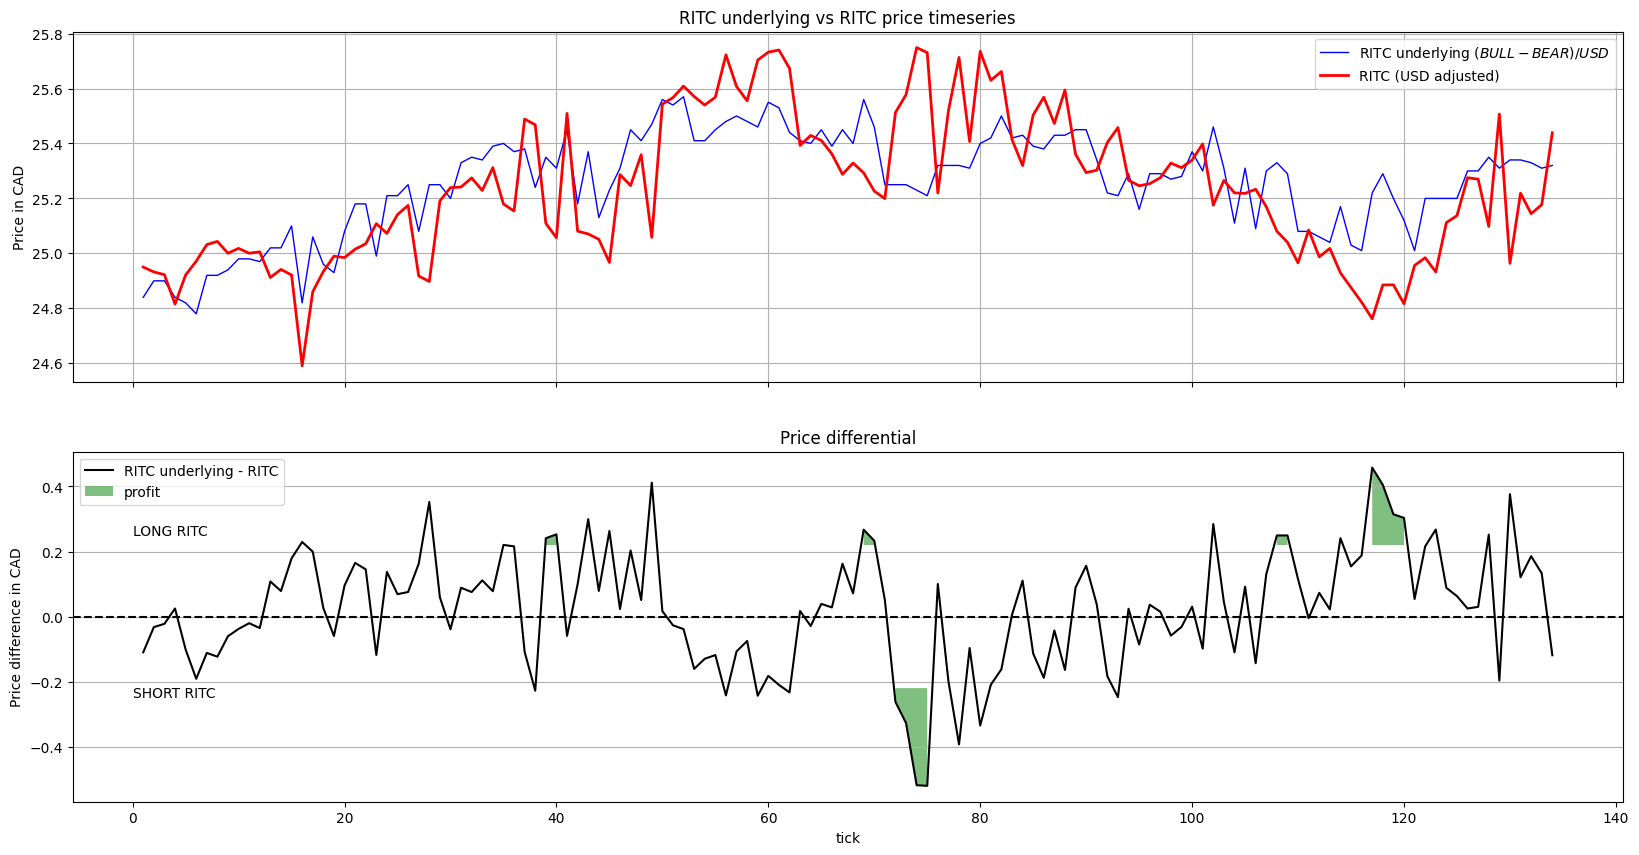

In [378]:
df_RITC_hist = app.getSecuritiesHistory("RITC").set_index("tick")[::-1]
df_BULL_hist = app.getSecuritiesHistory("BULL").set_index("tick")[::-1]
df_BEAR_hist = app.getSecuritiesHistory("BEAR").set_index("tick")[::-1]
df_USD_hist = app.getSecuritiesHistory("USD").set_index("tick")[::-1]
df = pandas.concat([df_RITC_hist.close, df_BULL_hist.close, df_BEAR_hist.close, df_USD_hist.close], axis=1)
df.columns = ["RITC", "BULL", "BEAR", "USD"]
df["RITC_undrlyng"] = df["BULL"] + df["BEAR"]
df["RITC"] = df["RITC"] * df["USD"]
commission = 0.12 # per share
slippage = 0.1 # per share
adj_commision = commission + slippage
f, axarr = plt.subplots(2, figsize=(20,10), sharex=True)
axarr[0].plot(df.index, df["RITC_undrlyng"], c="b", linewidth=1, label=r"RITC underlying $(BULL - BEAR)/USD$")
axarr[0].plot(df.index, df["RITC"], c="r", linewidth=2, label="RITC (USD adjusted)")
# for i in range(len(tendies_df)):
#     axarr[0].axvline(x=tendies_df.index[i], color='black', linewidth=0.5, linestyle='--')
#     axarr[0].axvline(x=tendies_df.iloc[i]["expires"], color='black', linewidth=0.5, linestyle='--')
#     axarr[0].axvspan(tendies_df.index[i], tendies_df.iloc[i]["expires"], alpha=0.1, color='green' if tendies_df.iloc[i]["action"] == "BUY" else "red")
#     axarr[0].scatter(tendies_df.index[i], tendies_df.iloc[i]["price"]*df.iloc[tendies_df.index[i]]["USD"], c="black", marker="x", s=100)

axarr[0].set_ylabel('Price in CAD')
axarr[0].grid()
axarr[0].legend()
axarr[0].set_title('RITC underlying vs RITC price timeseries')

axarr[1].plot(df.index, df["RITC_undrlyng"] - df["RITC"], c="black", label=r"RITC underlying - RITC")
axarr[1].annotate('LONG RITC', xy=(0, 0), xytext=(0, 0.25))
axarr[1].annotate('SHORT RITC', xy=(0, 0), xytext=(0, -0.25))
axarr[1].set_title('Price differential')
axarr[1].set_ylabel('Price difference in CAD')
axarr[1].fill_between(df.index, df["RITC_undrlyng"] - df["RITC"], adj_commision, where=df["RITC_undrlyng"] - df["RITC"] > adj_commision, facecolor='green', alpha=0.5, label="profit")
axarr[1].fill_between(df.index, df["RITC_undrlyng"] - df["RITC"], -adj_commision, where=df["RITC_undrlyng"] - df["RITC"] < -adj_commision, facecolor='green', alpha=0.5)
axarr[1].legend()
axarr[1].grid(axis='y')
axarr[1].axhline(y=0, color='black', linestyle='--')
axarr[1].set_xlabel('tick')


In [76]:
import scipy.stats as ss

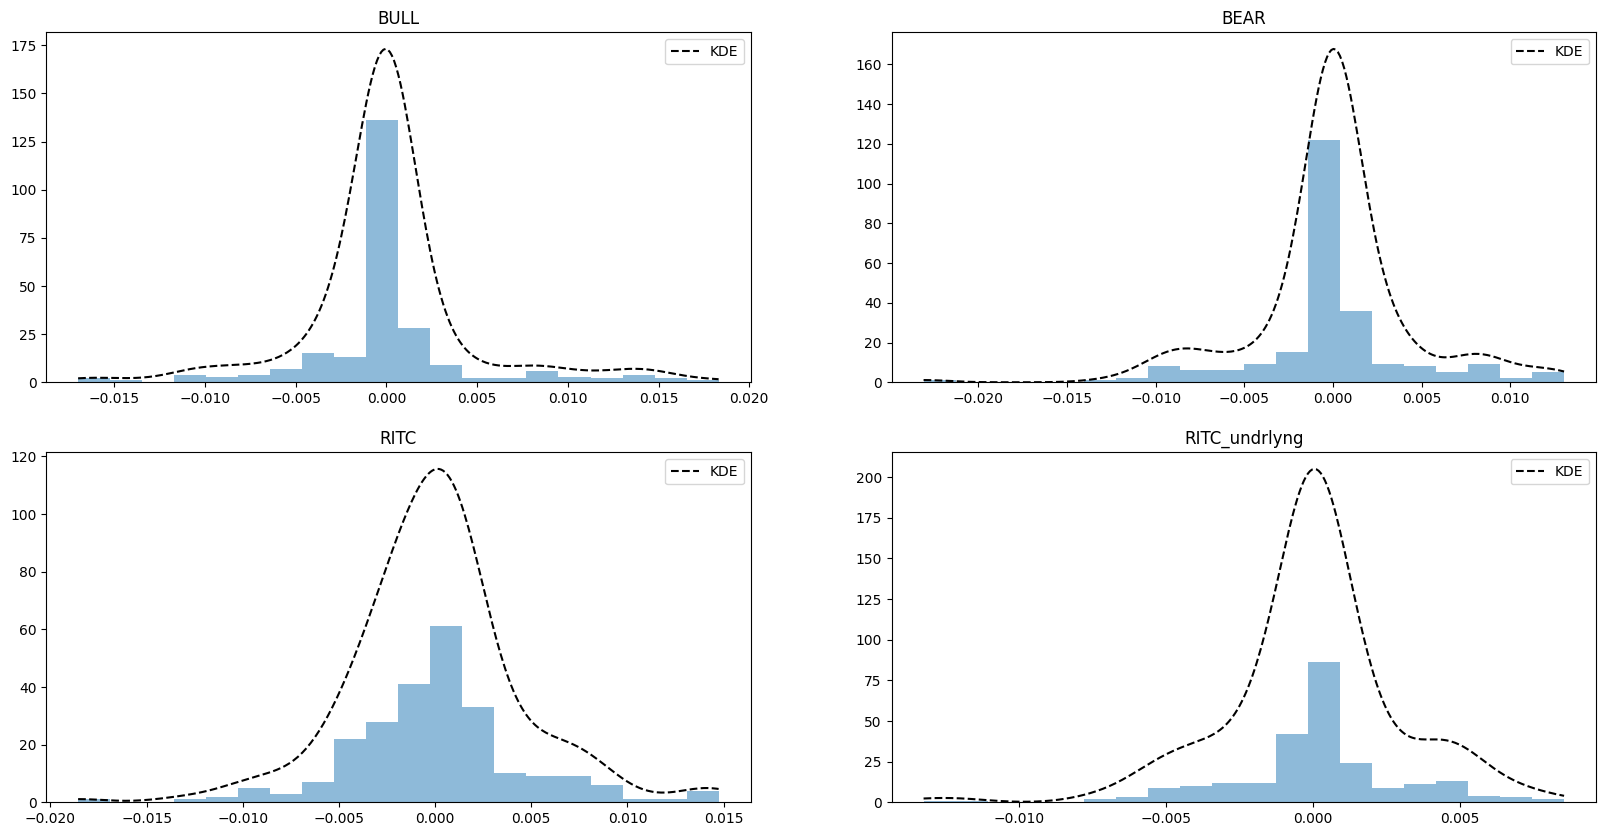

In [252]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))

pct_ch_df = df.pct_change().dropna()
pct_ch_df = pct_ch_df[["BULL", "BEAR", "RITC", "RITC_undrlyng"]]
# estimate Kernel Density and plot
for i in range(2):
    for j in range(2):
        axs[i,j].set_title(pct_ch_df.columns[i*2+j])
        axs[i,j].hist(pct_ch_df[pct_ch_df.columns[i*2+j]], alpha=0.5, bins=20)

        x = np.linspace(pct_ch_df[pct_ch_df.columns[i*2+j]].min(), pct_ch_df[pct_ch_df.columns[i*2+j]].max(), 301)
        kde = ss.gaussian_kde(pct_ch_df[pct_ch_df.columns[i*2+j]])
        axs[i,j].plot(x, kde.pdf(x), linestyle = "--", c="black", label='KDE')
        axs[i,j].legend()

In [253]:
securities = list(app.getSecurities().keys())
bidask = {sec: app.getSecuritiesBook(sec) for sec in securities}

In [254]:
for sec in securities:
    bidask[sec]["bids"]["ev_vwap"] = ((bidask[sec]["bids"]["price"] * bidask[sec]["bids"]["quantity"])/bidask[sec]["bids"]["quantity"]).expanding().mean()
    bidask[sec]["asks"]["ev_vwap"] = ((bidask[sec]["asks"]["price"] * bidask[sec]["asks"]["quantity"])/bidask[sec]["asks"]["quantity"]).expanding().mean()

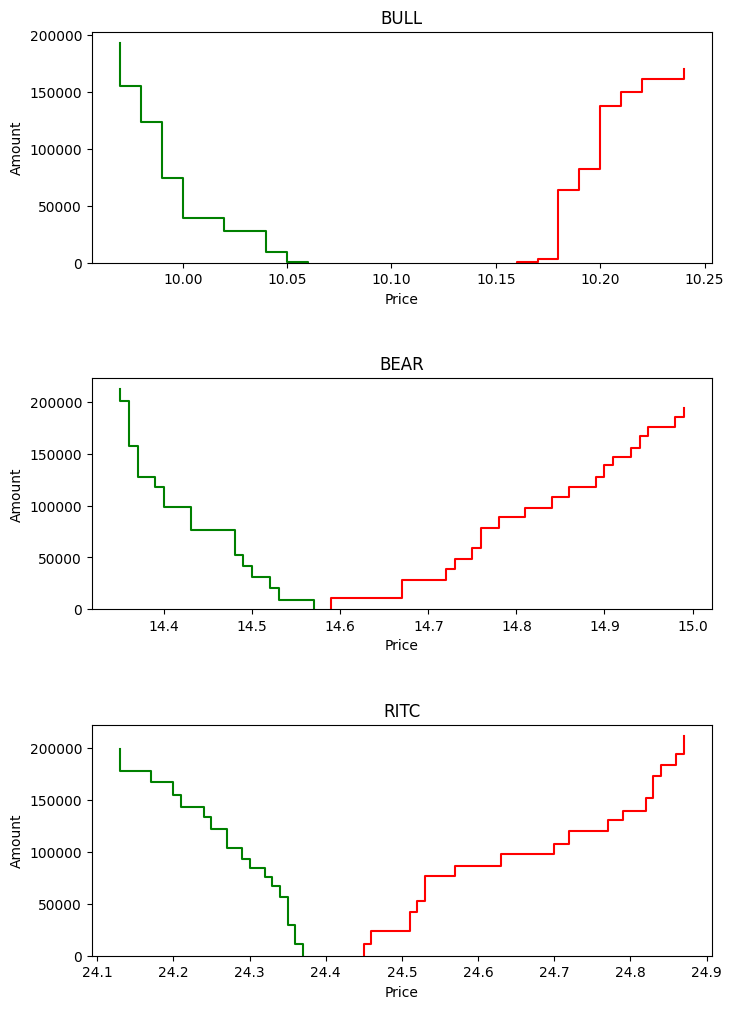

In [255]:
import seaborn as sns


fig, ax = plt.subplots(3, 1, figsize=(8, 12))
fig.subplots_adjust(hspace=0.5)

for i, val in enumerate(securities[2:]):
    # bid side
    sns.ecdfplot(x="price", weights="quantity", stat="count", complementary=True, data=bidask[val]["bids"], ax=ax[i], color='g')
    # ask side
    sns.ecdfplot(x="price", weights="quantity", stat="count", data=bidask[val]["asks"], ax=ax[i], color='r')
    ax[i].set_title(val)
    ax[i].set_xlabel("Price")
    ax[i].set_ylabel("Amount")

In [313]:
bidask_BEAR["bids"]

,period,tick,trader_id,ticker,quantity,price,type,action,quantity_filled,vwap,status
order_id,,,,,,,,,,,
2433,1,168,h1,BEAR,1000.0,16.74,LIMIT,BUY,0.0,NaN,OPEN
2394,1,166,ANON,BEAR,7300.0,16.73,LIMIT,BUY,3000.0,16.73,OPEN
2372,1,165,h1,BEAR,1000.0,16.70,LIMIT,BUY,0.0,NaN,OPEN
2359,1,164,ANON,BEAR,7200.0,16.69,LIMIT,BUY,0.0,NaN,OPEN
2382,1,165,ANON,BEAR,9100.0,16.69,LIMIT,BUY,0.0,NaN,OPEN
2347,1,163,h1,BEAR,100.0,16.68,LIMIT,BUY,0.0,NaN,OPEN
2334,1,162,h1,BEAR,1000.0,16.67,LIMIT,BUY,0.0,NaN,OPEN
2432,1,168,ANON,BEAR,9800.0,16.66,LIMIT,BUY,0.0,NaN,OPEN
2285,1,159,ANON,BEAR,8100.0,16.65,LIMIT,BUY,1600.0,16.65,OPEN


In [41]:
app.getTenders()

{3541: {'period': 1,
  'tick': 235,
  'expires': 241,
  'caption': 'An institution would like to BUY 71000 shares of RITC from you at a price of 24.26.  Would you like to SELL the shares to them?',
  'ticker': 'RITC',
  'quantity': 71000.0,
  'action': 'SELL',
  'is_fixed_bid': True,
  'price': 24.26}}

In [114]:
tend = app.getTenders()

In [115]:
tend

{541: {'period': 1,
  'tick': 47,
  'expires': 53,
  'caption': 'An institution would like to SELL 98000 shares of RITC to you at a price of 24.55.  Would you like to BUY the shares from them?',
  'ticker': 'RITC',
  'quantity': 98000.0,
  'action': 'BUY',
  'is_fixed_bid': True,
  'price': 24.55}}